## Importing the Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import mplfinance as mpf
from prophet.plot import plot_plotly, add_changepoints_to_plot
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
#from fbprophet import Prophet


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Masters/3 sem/Software Dev for AI/Project 2/all_stocks_5yr.csv")

In [ ]:
df.head()

date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [ ]:
df.dtypes

date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
Name       object
dtype: object

In [ ]:
df.describe()

open           high            low          close  \
count  619029.000000  619032.000000  619032.000000  619040.000000   
mean       83.023334      83.778311      82.256096      83.043763   
std        97.378769      98.207519      96.507421      97.389748   
min         1.620000       1.690000       1.500000       1.590000   
25%        40.220000      40.620000      39.830000      40.245000   
50%        62.590000      63.150000      62.020000      62.620000   
75%        94.370000      95.180000      93.540000      94.410000   
max      2044.000000    2067.990000    2035.110000    2049.000000   

             volume  
count  6.190400e+05  
mean   4.321823e+06  
std    8.693610e+06  
min    0.000000e+00  
25%    1.070320e+06  
50%    2.082094e+06  
75%    4.284509e+06  
max    6.182376e+08

In [ ]:
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [ ]:
# rename Name to ticks
rdf = df.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)
print(rdf.isnull().sum())
# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

# new dataframe info
new_df.info()


date      0
open      0
high      0
low       0
close     0
volume    0
ticks     0
dtype: int64


<ipython-input-9-6911133f2155>:9: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


In [ ]:
# find the average volume of each stocks using function and sort top 10 most traded stocks for further analysis
mean_dict = {}

# find average of volume traded over a period of time using for loops
for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks'] == key ]['volume'].mean()
    mean_dict[key]= value

print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top10_s = avaerage_s.sort_values(ascending=False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s.index)


Length of the mean of ticks dictionary: 505
Top 10 company tickers with highest average traded stock volume:
 Index(['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO'], dtype='object')


In [ ]:
# function to return top 10 sub dataframe
def subdataframe(df, tick):

    # top 10 ticks
    ticks = list(top10_s.index)

    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""

    ndf = new_df[new_df['ticks'] == tick]
    return ndf


In [ ]:
# company dict for respective ticks (TOP 10 STOCKS BY AVERAGE TRAE VOLUME)
company_dict = {'BAC':'Bank of America',
                'AAPL':'Apple',
                'GE':'General Electric',
                'F':'Ford Motor Company',
                'FB':'Facebook',
                'MSFT':'Microsoft',
                'AMD':'Adavanced Micro Devices',
                'MU':'Micron Technology',
                'INTC':'Intel Corp',
                'CSCO':'Cisco'
               }

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')


# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)

print('\t\tStart Date\t\t\t\t\tEnd Date')
print(f"BAC\t\t{bac_df['date'].min()}\t\t\t{bac_df['date'].max()}")
print(f"AAPL\t\t{aapl_df['date'].min()}\t\t\t{aapl_df['date'].max()}")
print(f"GE\t\t{ge_df['date'].min()}\t\t\t{ge_df['date'].max()}")
print(f"F\t\t{f_df['date'].min()}\t\t\t{f_df['date'].max()}")
print(f"FB\t\t{fb_df['date'].min()}\t\t\t{fb_df['date'].max()}")
print(f"MSFT\t\t{msft_df['date'].min()}\t\t\t{msft_df['date'].max()}")
print(f"AMD\t\t{amd_df['date'].min()}\t\t\t{amd_df['date'].max()}")
print(f"MU\t\t{mu_df['date'].min()}\t\t\t{mu_df['date'].max()}")
print(f"INTC\t\t{intc_df['date'].min()}\t\t\t{intc_df['date'].max()}")
print(f"CSCO\t\t{csco_df['date'].min()}\t\t\t{csco_df['date'].max()}")


		Start Date					End Date
BAC		2013-02-08 00:00:00			2018-02-07 00:00:00
AAPL		2013-02-08 00:00:00			2018-02-07 00:00:00
GE		2013-02-08 00:00:00			2018-02-07 00:00:00
F		2013-02-08 00:00:00			2018-02-07 00:00:00
FB		2013-02-08 00:00:00			2018-02-07 00:00:00
MSFT		2013-02-08 00:00:00			2018-02-07 00:00:00
AMD		2013-02-08 00:00:00			2018-02-07 00:00:00
MU		2013-02-08 00:00:00			2018-02-07 00:00:00
INTC		2013-02-08 00:00:00			2018-02-07 00:00:00
CSCO		2013-02-08 00:00:00			2018-02-07 00:00:00


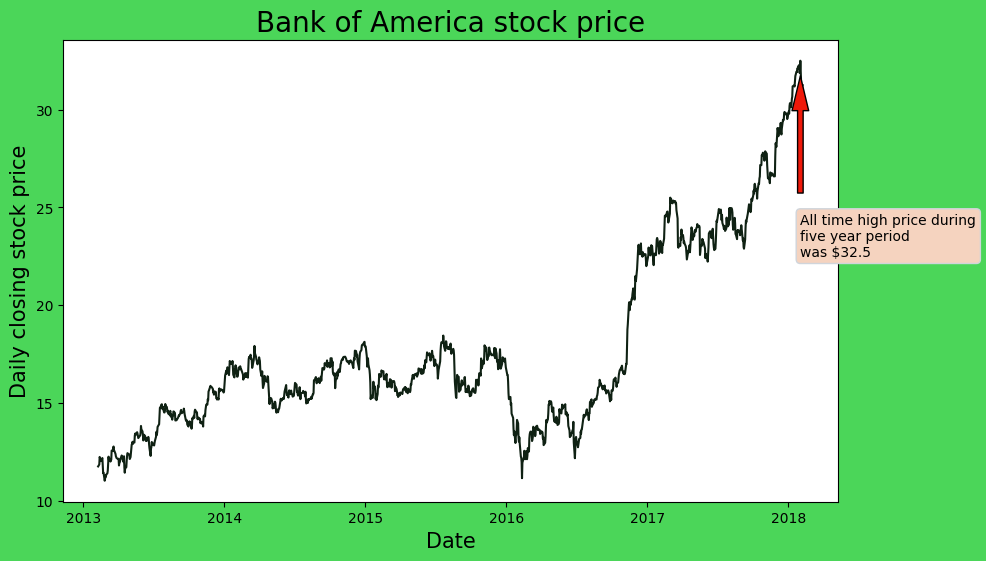

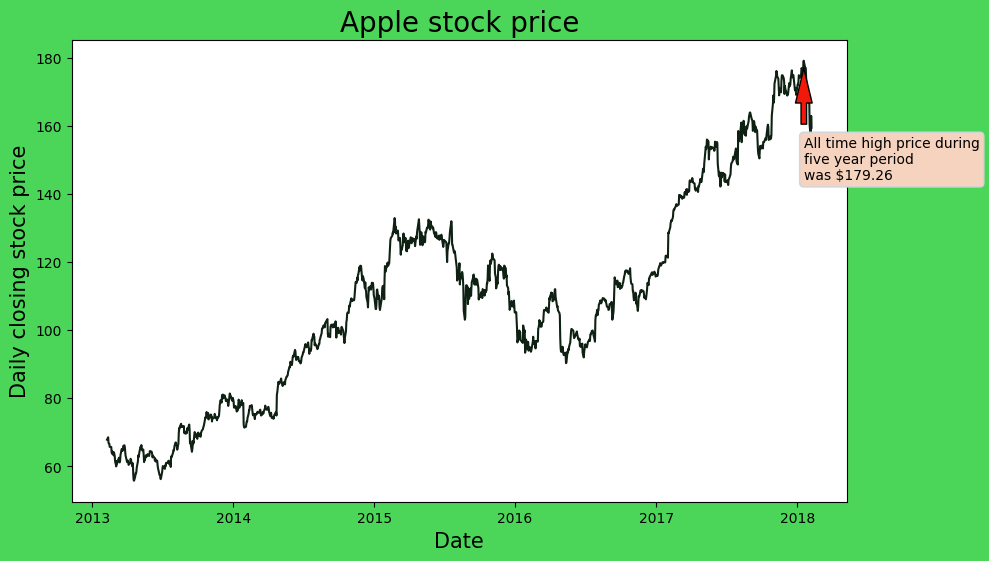

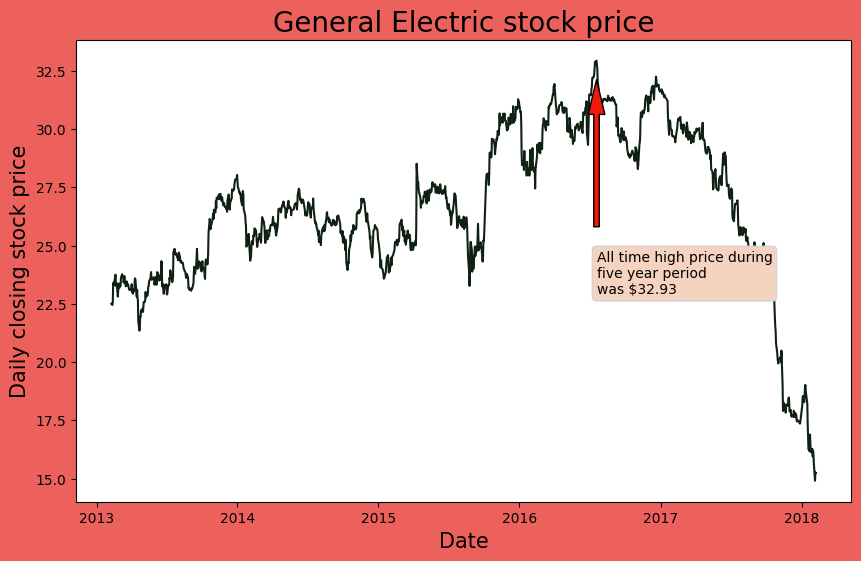

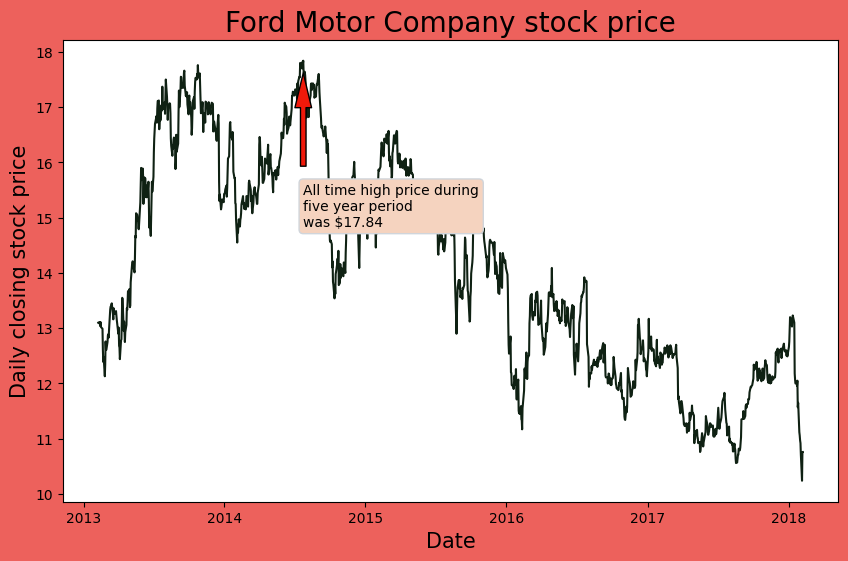

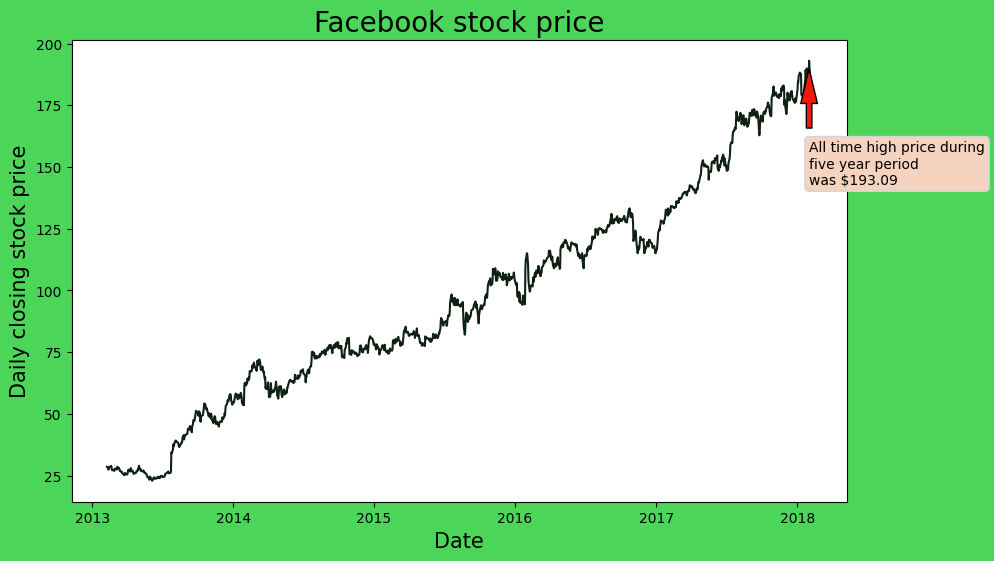

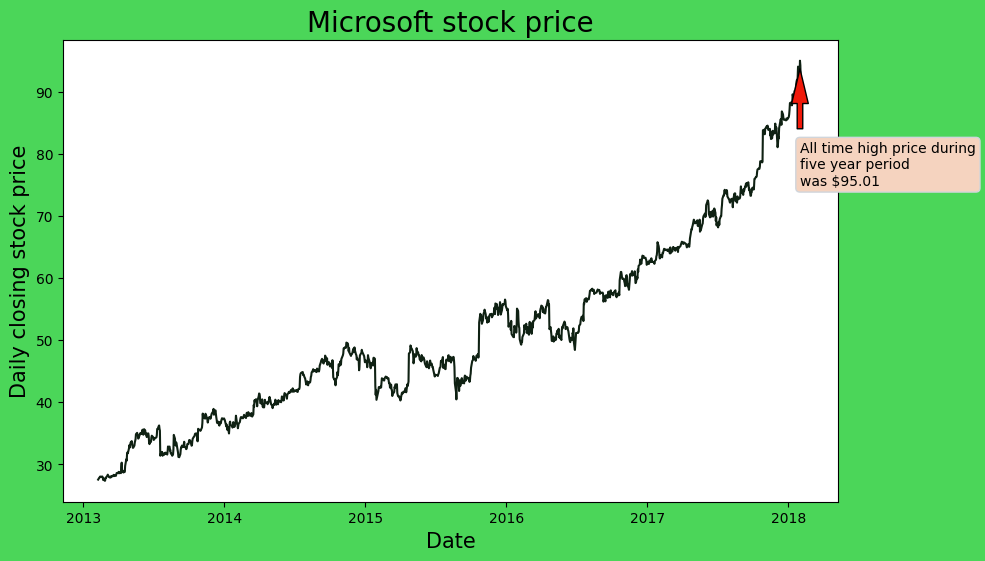

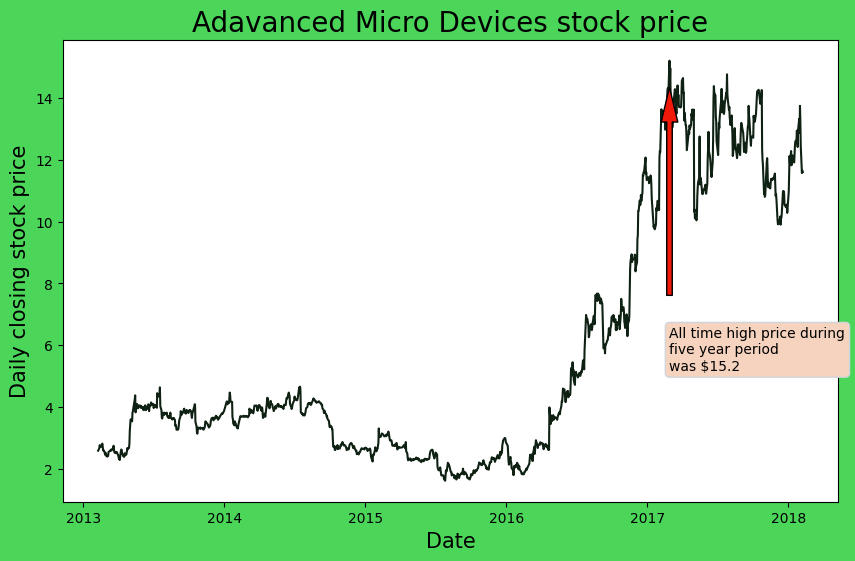

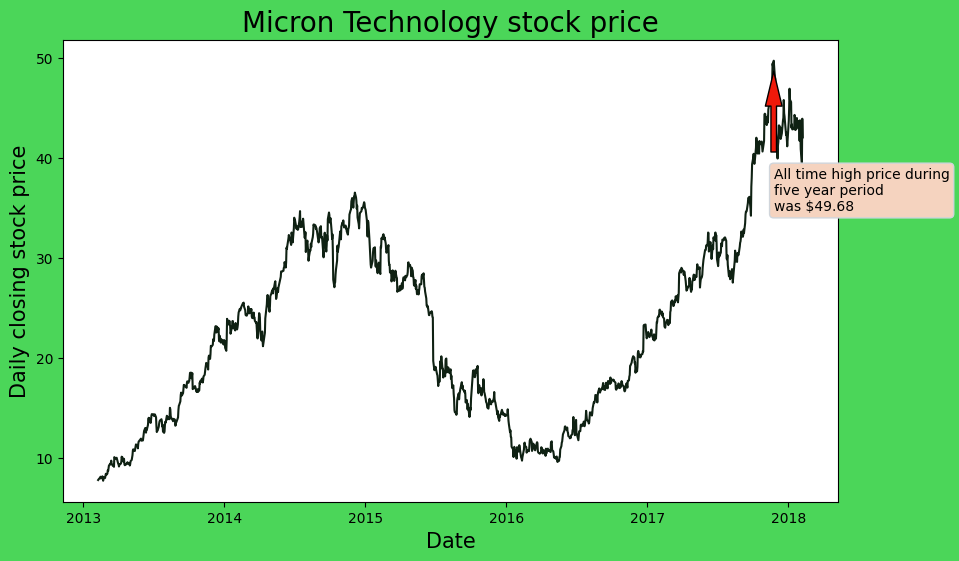

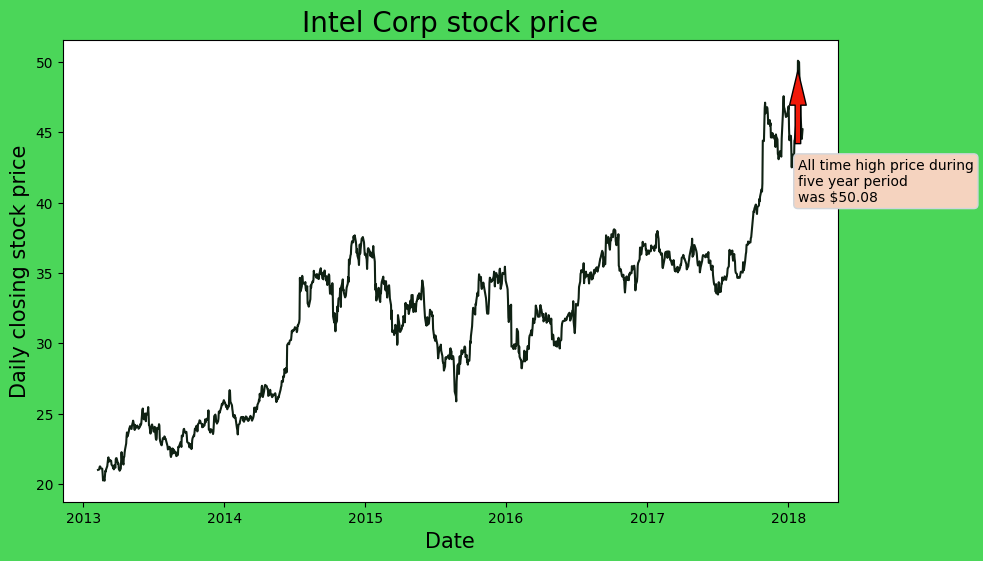

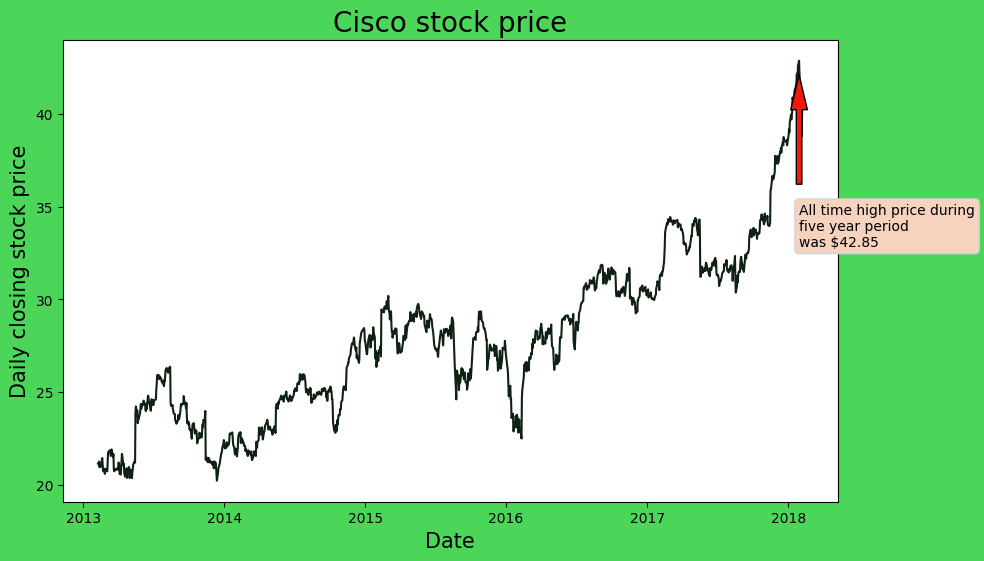

In [ ]:
# Closing stock price visualizations & maximum price during 5 years
# function return closing stock price over a 5 years of time period
def closing_stock_price(df):

    # define highest stock over 5 period of time with date of the same
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values

    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()

# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)


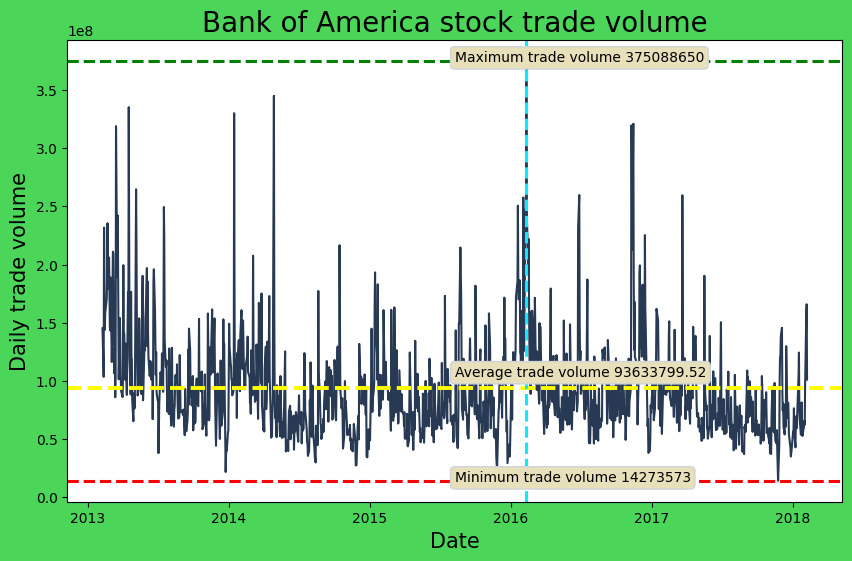

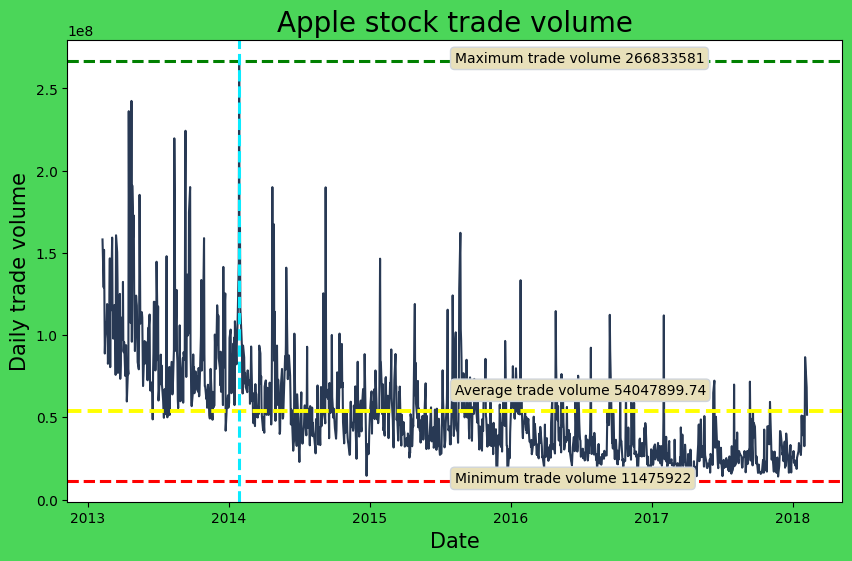

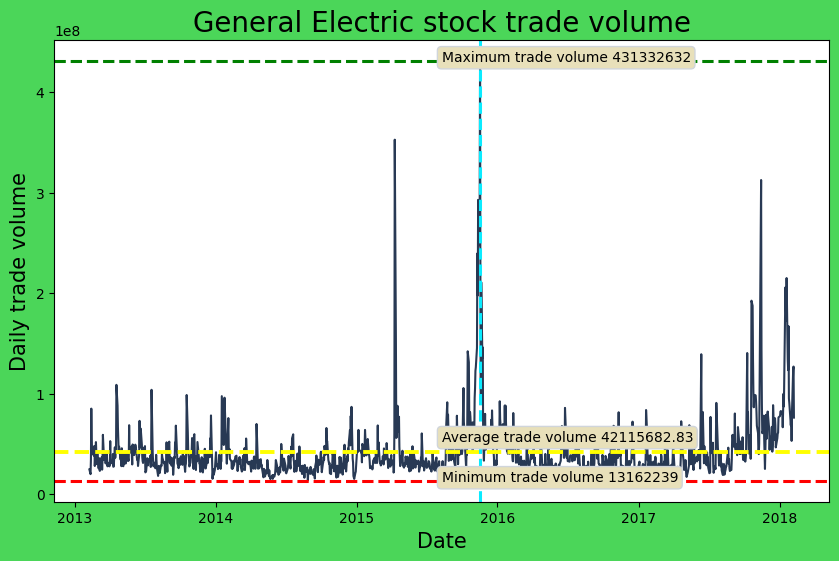

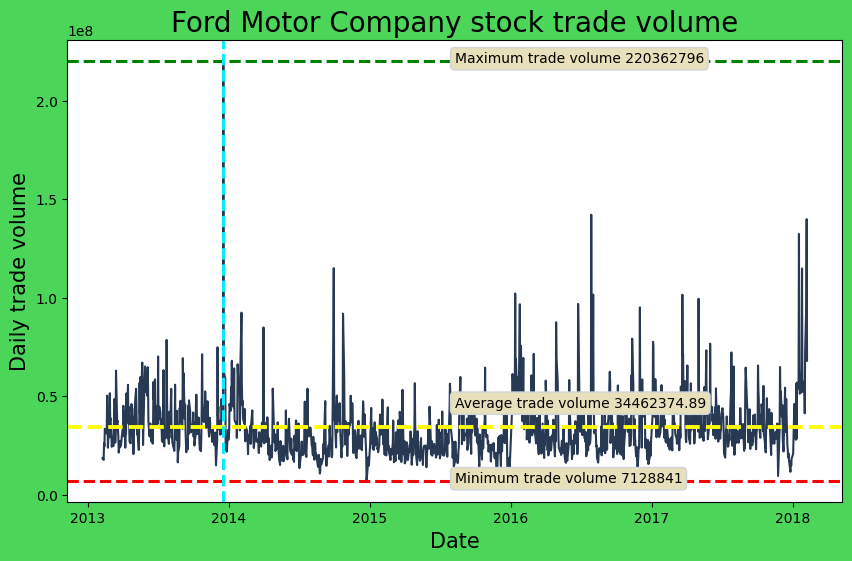

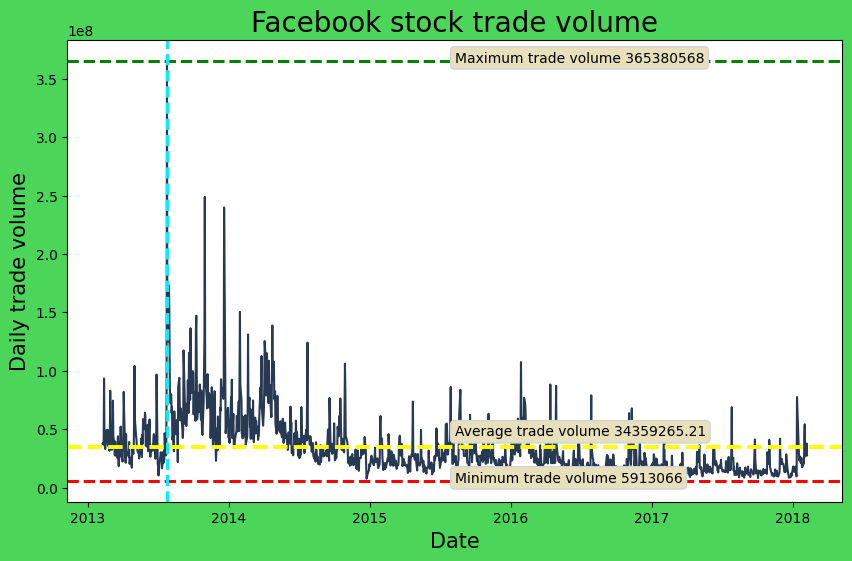

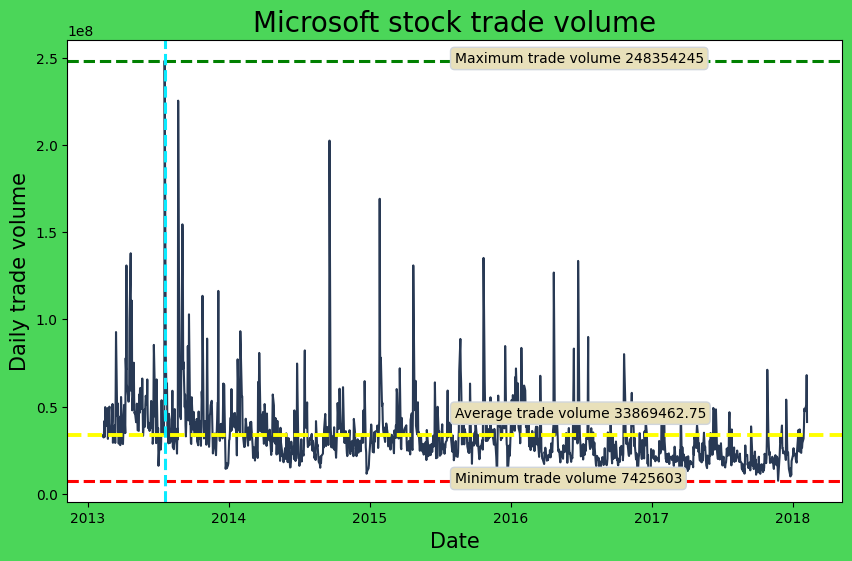

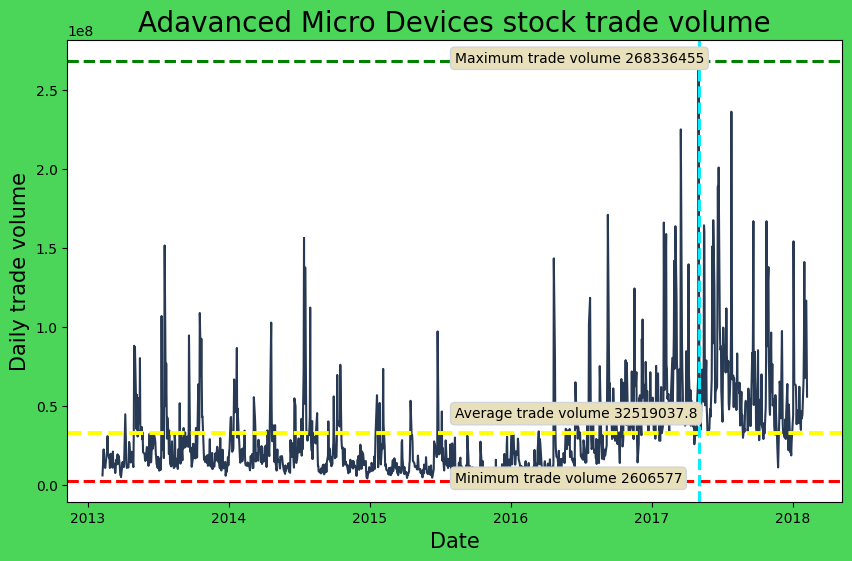

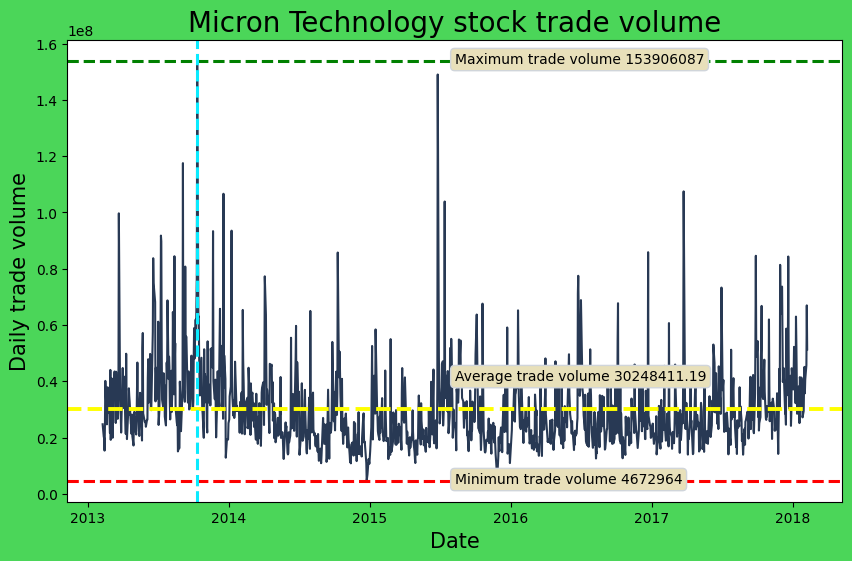

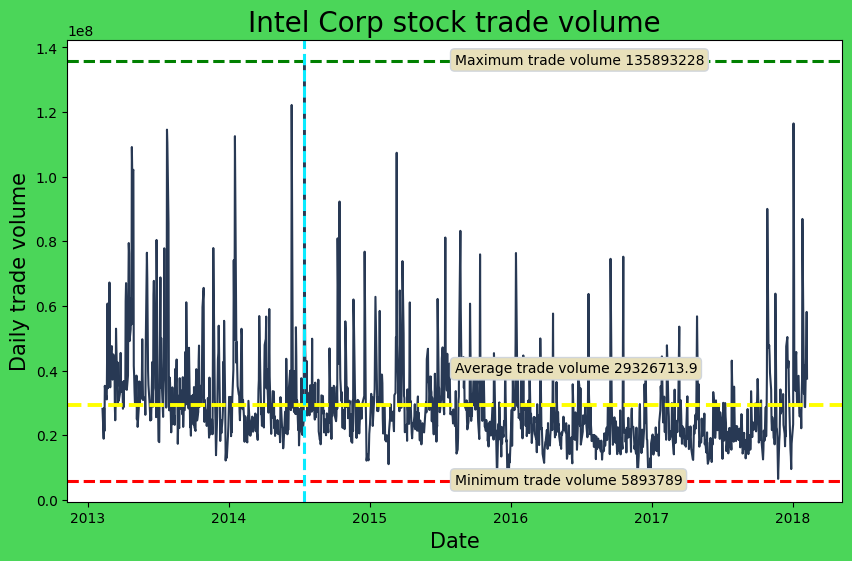

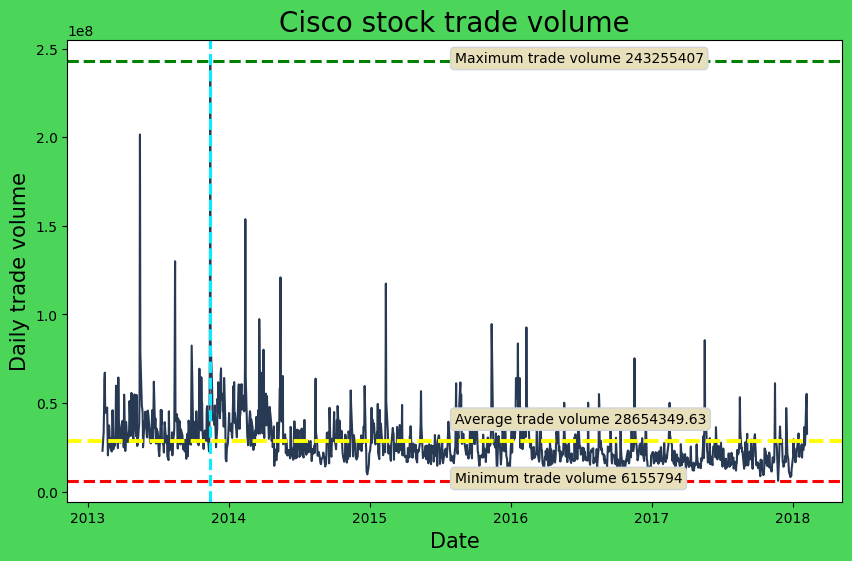

In [ ]:
#Above visualizations depicts what was the maximum, minimum and average trade volume overa period of 2013-2018.

# function to visualize trade volume of stocks
def trade_vol(df):

    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    # y coord for max trade vol
    max_y = df['volume'].max()
    # y coord for min trade vol
    min_y = df['volume'].min()

    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}",
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}",
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}",
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )

    plt.show()


# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)


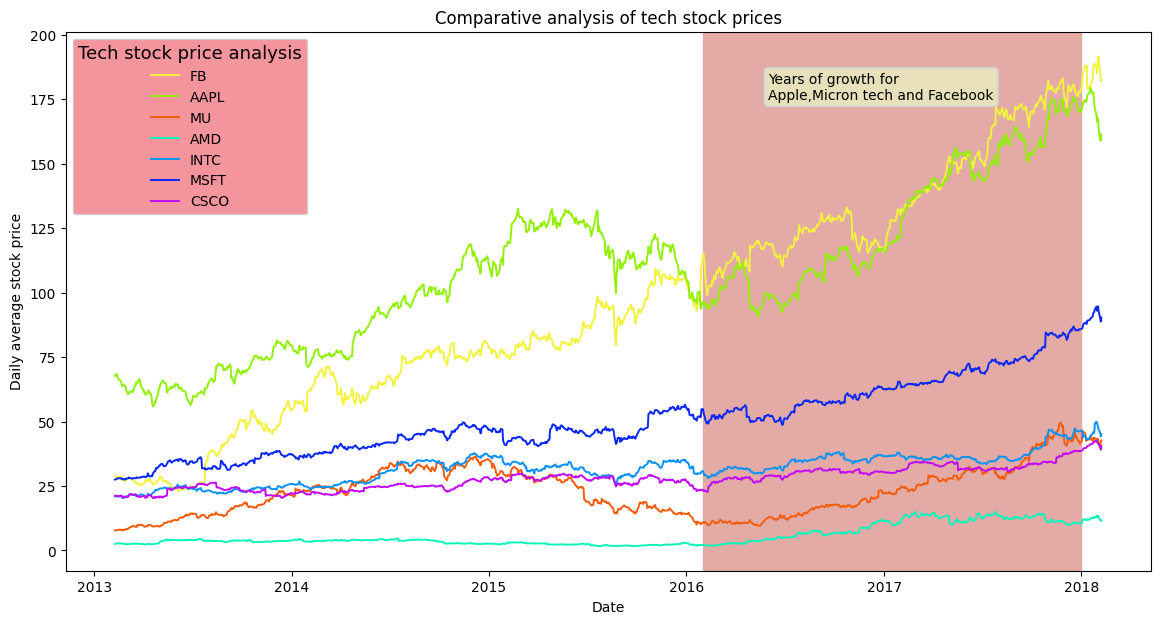

In [ ]:
# tech stocks price comparison
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(fb_df['date'], fb_df['daily_mean'],label='FB', color='#f2f23f', lw=1.4)
ax.plot(aapl_df['date'], aapl_df['daily_mean'],label='AAPL', color='#92f005', lw=1.4)
ax.plot(mu_df['date'], mu_df['daily_mean'],label='MU', color='#f55c0a', lw=1.4)
ax.plot(amd_df['date'], amd_df['daily_mean'],label='AMD', color='#0af5ba', lw=1.4)
ax.plot(intc_df['date'], intc_df['daily_mean'],label='INTC', color='#0a93f5', lw=1.4)
ax.plot(msft_df['date'], msft_df['daily_mean'],label='MSFT', color='#0a29f5', lw=1.4)
ax.plot(csco_df['date'], csco_df['daily_mean'],label='CSCO', color='#c20af5', lw=1.4)
ax.axvspan(*mdates.datestr2num(['2/1/2016','12/31/2017']), color='#e3aaa6')
ax.set_title("Comparative analysis of tech stock prices")
ax.annotate("Years of growth for\nApple,Micron tech and Facebook", xy=(mdates.datestr2num('6/1/2016'),175),
           bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'))
ax.set_xlabel("Date")
ax.set_ylabel("Daily average stock price")
ax.legend(facecolor='#f27985', fontsize="medium", title="Tech stock price analysis", title_fontsize=13)

plt.show()


It is very clear that 'FB' stock was one of the most expensive among all 7 tech stocks
stock ticker 'AMD' was among the cheapest to buy compared to other stocks
From above chart we can also conclude that stocks like 'FB' and 'AAPL' were also among the most volatile in nature than other stocks


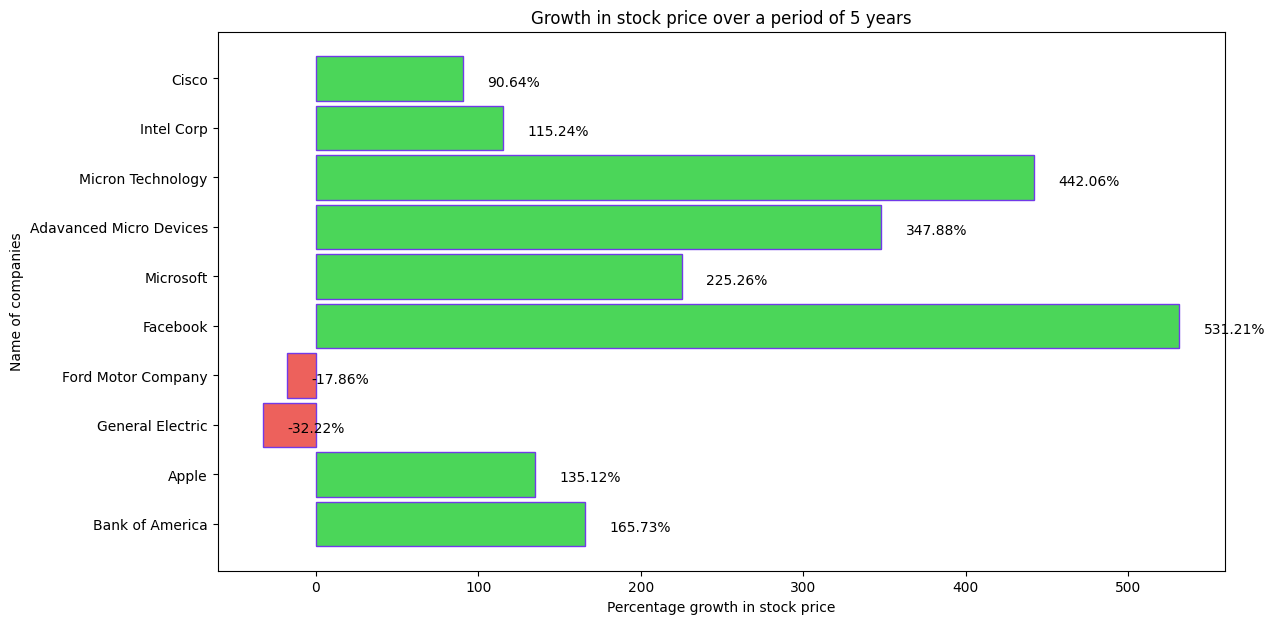

In [ ]:
# list of stock dataframes
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

# loop through the the list_df to find mini and maxi of each stocks
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

# find list of abosolute difference between both stock price
diff = np.array(maxi) - np.array(mini)

# find the percentage growth
growth = (diff/mini)*100
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

# visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13,7))
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=['#4bd659','#4bd659','#ed615c','#ed615c','#4bd659',
                                                             '#4bd659','#4bd659','#4bd659','#4bd659','#4bd659'],
       edgecolor='#713ae8')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")
plt.show()

In [ ]:
# python's scipy.stats module has ttest_1samp method we allows to prove this hypothesis
result_dict = {}
for df in list_df:
    result = stats.ttest_1samp(df['daily return'], 0)
    result_dict[df['ticks'].unique()[0]] = result
result_dict

{'BAC': TtestResult(statistic=-0.3532776176429947, pvalue=0.7239395130534507, df=1258),
 'AAPL': TtestResult(statistic=0.41429430560560776, pvalue=0.6787292124343913, df=1258),
 'GE': TtestResult(statistic=-0.6899014787481074, pvalue=0.4903833915917716, df=1258),
 'F': TtestResult(statistic=-1.829967497402379, pvalue=0.06749132535767648, df=1258),
 'FB': TtestResult(statistic=0.43179923117451596, pvalue=0.6659613318143065, df=1258),
 'MSFT': TtestResult(statistic=2.936864998172622, pvalue=0.00337582087561039, df=1258),
 'AMD': TtestResult(statistic=0.5320769266138293, pvalue=0.5947666691710993, df=1258),
 'MU': TtestResult(statistic=-0.3912233565721498, pvalue=0.6956983959552626, df=1258),
 'INTC': TtestResult(statistic=3.0472693720373076, pvalue=0.002357434011831407, df=1258),
 'CSCO': TtestResult(statistic=2.6892871186777536, pvalue=0.007255138945761972, df=1258)}

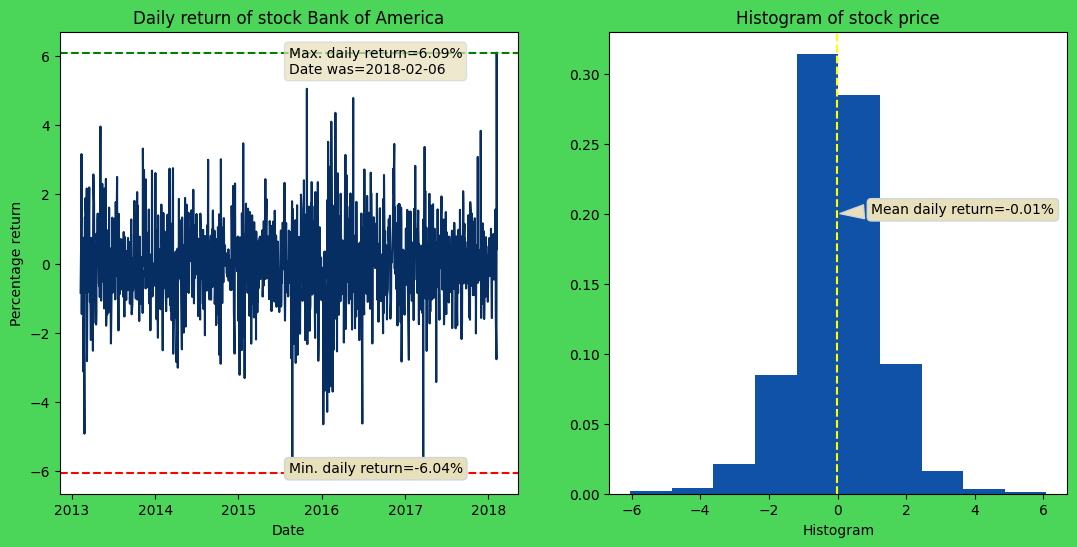

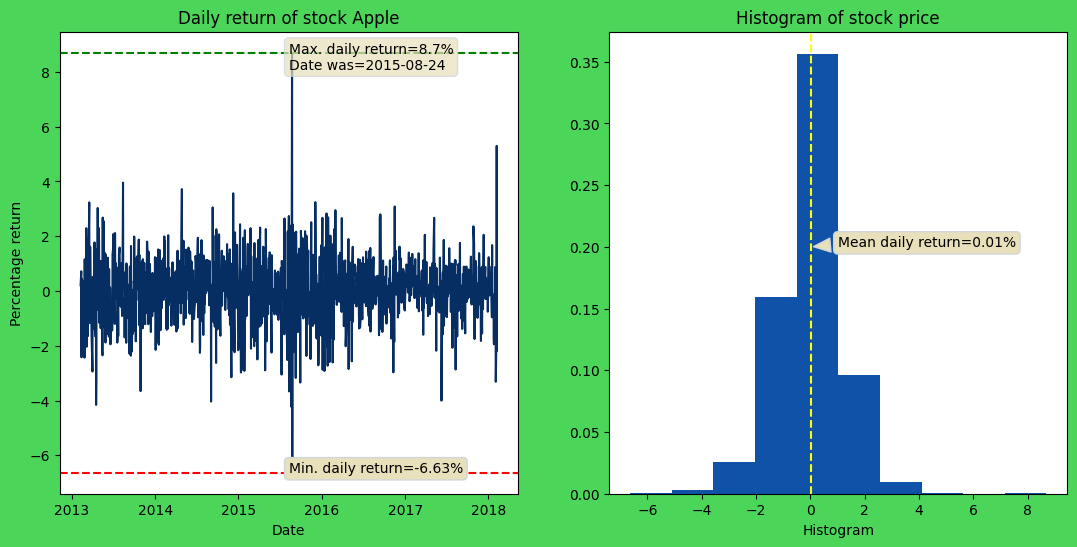

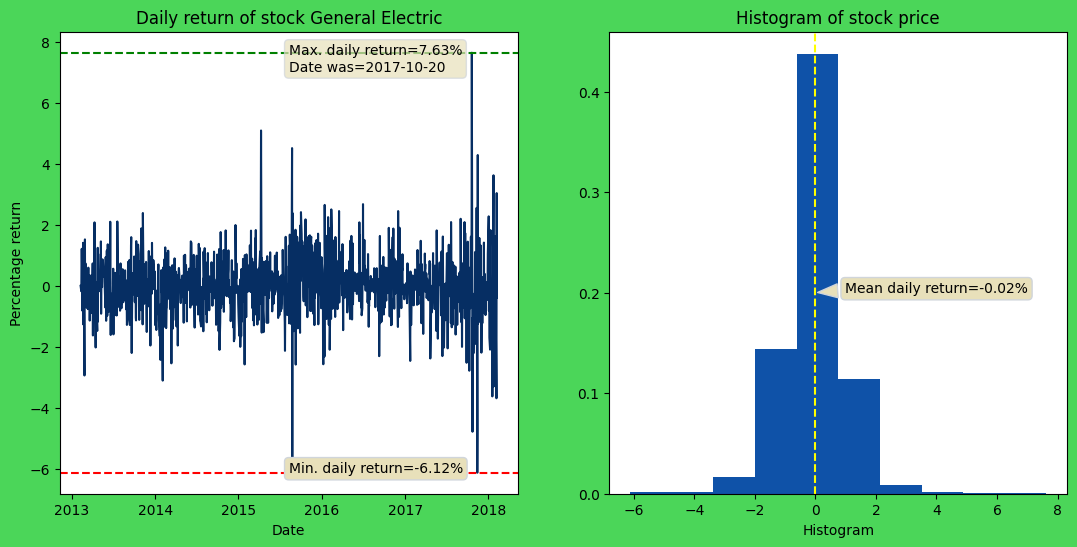

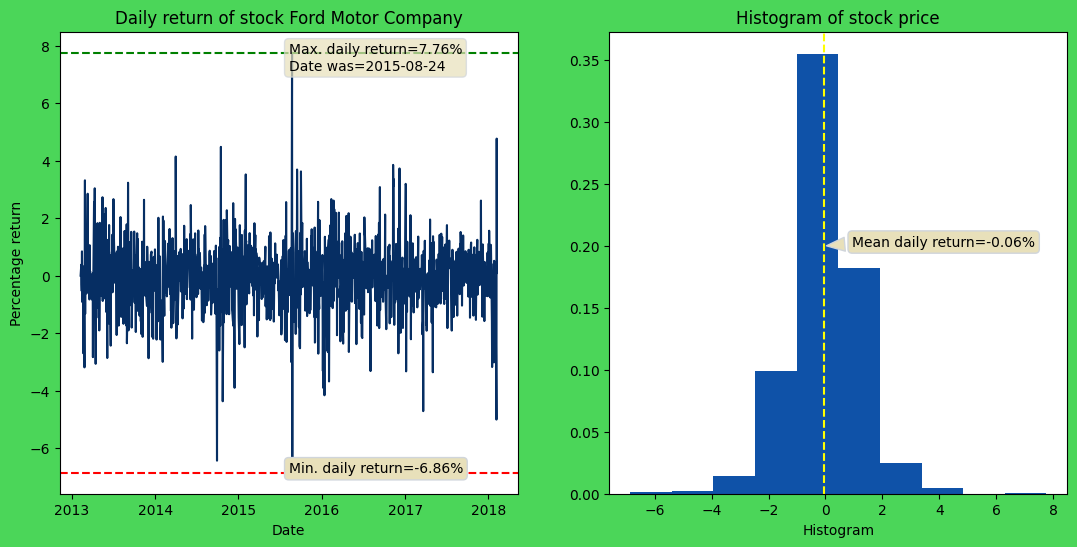

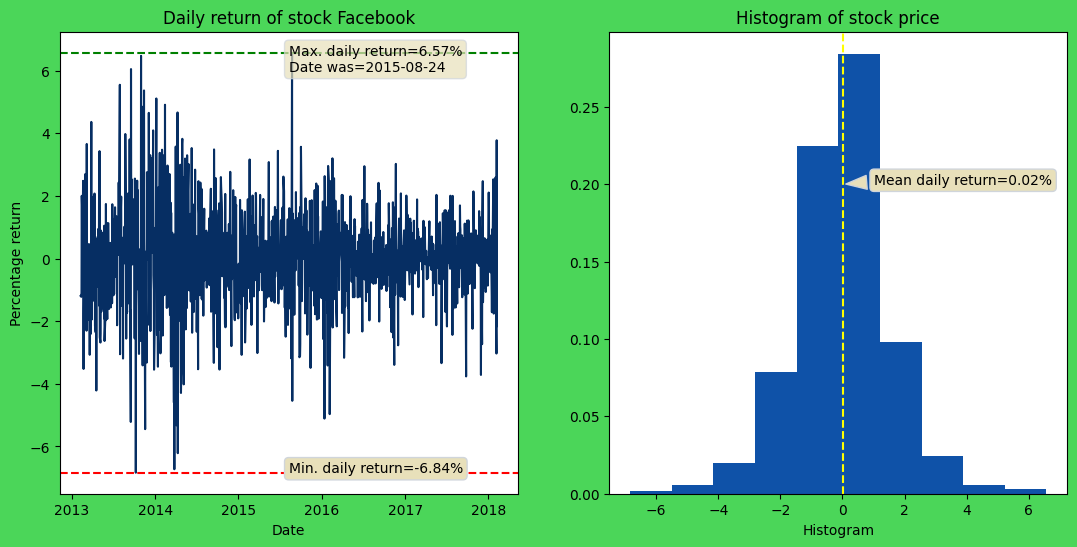

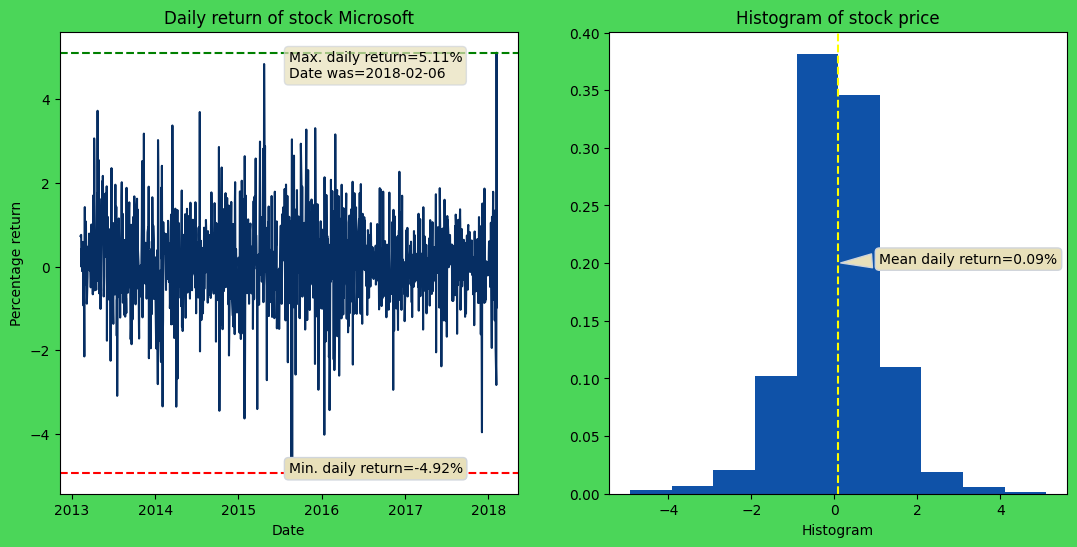

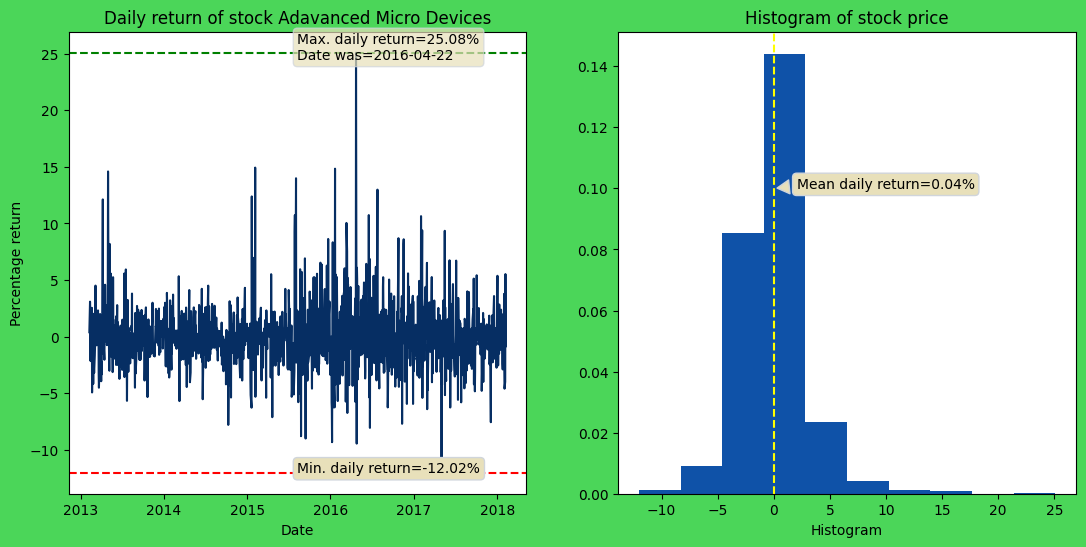

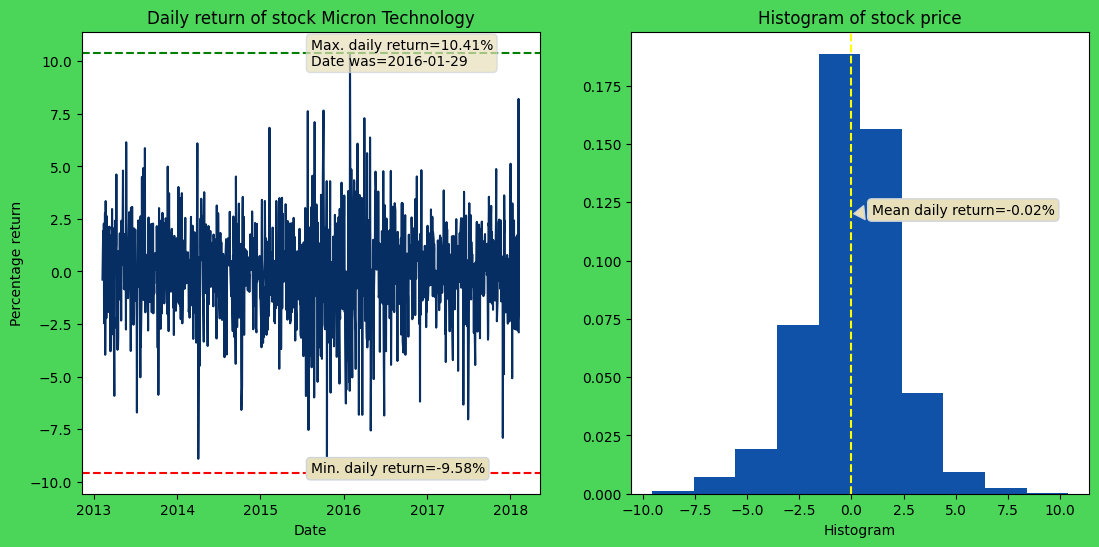

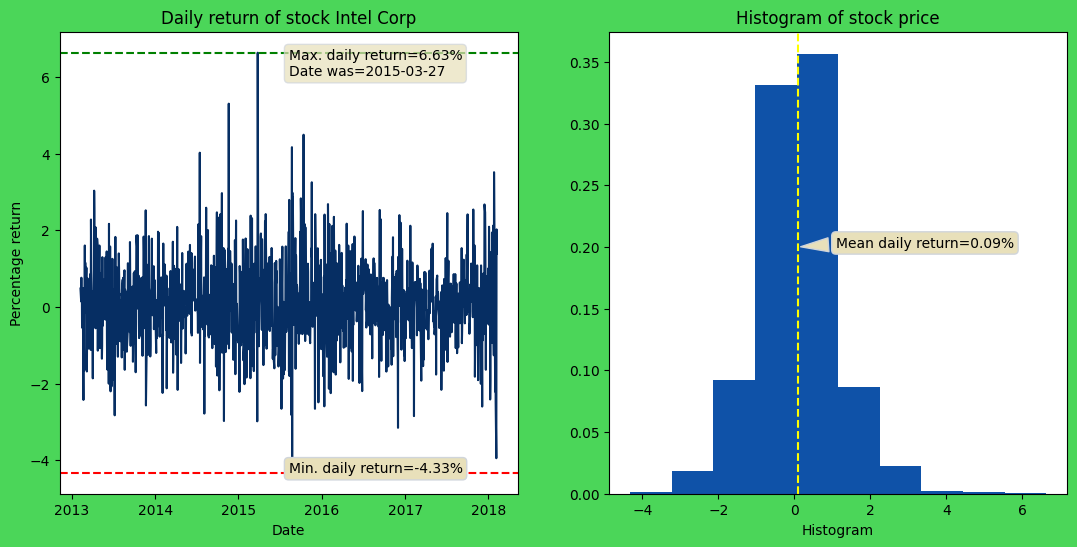

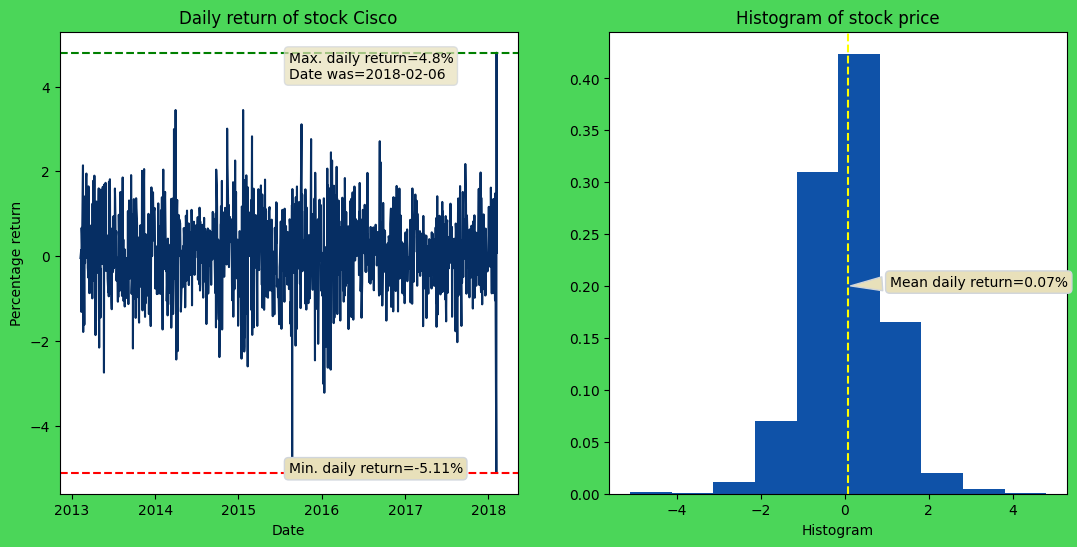

In [ ]:
###### function to plot daily return and histogram of 10 stocks
def daily_return(df):

    # assign variables to annotation positions
    ave_x = df['date'].mean()
    y_max = df['daily return'].max()
    y_max_date = df[df['daily return'] == df['daily return'].max()]['date'].values
    dt = pd.to_datetime(y_max_date, '%Y%m%d%H%M%S')
    xb = dt.item().date()
    y_min = df['daily return'].min()
    y_mean = df['daily return'].mean()

    plt.figure(figsize=(13,6), facecolor='#4bd659')

    plt.subplot(121)
    plt.plot(df['date'], df['daily return'], color='#062e63')
    plt.axhline(y=df['daily return'].max(), color='green', ls='--')
    plt.axhline(y=df['daily return'].min(), color='red', ls='--')
    plt.xlabel('Date')
    plt.ylabel("Percentage return")
    plt.annotate(f"Min. daily return={round(df['daily return'].min(),2)}%",
                xy=(ave_x,y_min),xytext=(ave_x,y_min),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    plt.annotate(f"Max. daily return={round(df['daily return'].max(),2)}%\nDate was={xb}",
                xy=(ave_x,y_max),xytext=(ave_x,y_max-0.6),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db', alpha=0.7)
                 )
    plt.title(f"Daily return of stock {df['co_name'].unique()[0]}")

    plt.subplot(122)
    plt.hist(df['daily return'], density=True, color='#0f52a8')
    plt.xlabel('Histogram')
    plt.axvline(x=df['daily return'].mean(), color='yellow', ls='--')
    if df['ticks'].unique()[0] == 'AMD':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%",
                xy=(y_mean,0.10),xytext=(y_mean+2,0.10),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba',
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    elif df['ticks'].unique()[0] == 'MU':
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%",
                xy=(y_mean,0.12),xytext=(y_mean+1,0.12),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba',
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    else:
        plt.annotate(f"Mean daily return={round(df['daily return'].mean(),2)}%",
                xy=(y_mean,0.20),xytext=(y_mean+1,0.20),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db'),
                arrowprops=dict(arrowstyle="wedge,tail_width=1.",facecolor='#e8e0ba',
                            edgecolor='#d0d5db',
                            relpos=(0.1,0.5)
                            )
                 )
    plt.title(f"Histogram of stock price")

    plt.show()

# call the function with dataframe
daily_return(bac_df)
daily_return(aapl_df)
daily_return(ge_df)
daily_return(f_df)
daily_return(fb_df)
daily_return(msft_df)
daily_return(amd_df)
daily_return(mu_df)
daily_return(intc_df)
daily_return(csco_df)

In [ ]:
def candlestick_chart(df):
    trace = go.Candlestick(x=df['date'],
                          open=df['open'],
                          high=df['high'],
                          low=df['low'],
                          close=df['close'])
    layout ={
    'title': f"{df['co_name'].unique()[0]} Historical Stock Price",
    'xaxis': {'title': 'Date'
             },
    'yaxis': {'title': 'Stock Price (USD$)'}
}


    data = [trace]

    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(xaxis_rangeslider_visible=False, paper_bgcolor='#4bd659')
    fig.show()

# plot the charts using this function
candlestick_chart(bac_df)
candlestick_chart(aapl_df)
candlestick_chart(ge_df)
candlestick_chart(f_df)
candlestick_chart(fb_df)
candlestick_chart(msft_df)
candlestick_chart(amd_df)
candlestick_chart(mu_df)
candlestick_chart(intc_df)
candlestick_chart(csco_df)

In [ ]:
def mav_function(df):

    # calclulate moving averages of 10,50 and 200 days
    df['10_d_avg'] = df['close'].rolling(window=10).mean()
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg'] = df['close'].rolling(window=200).mean()

    return df

# let's analyse apple and facebook stocks using moving averages methods
aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)


In [ ]:
# plot moving avearges charts of apple and facebook
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df):
    df = df.set_index('date')

    fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)
    # set colors and cols names to be plotted
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg','50_d_avg','200_d_avg']

    for col, c in zip(avgs, colors):
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}},1,1)
    for col in ['close']:
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': 'closing price', 'line': {'color': '#393f5e'}},2,1)

    fig['layout'].update(height=800,title=f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}",
                    paper_bgcolor='#4bd659', plot_bgcolor='#F2DFCE')
    fig.show()

In [ ]:
# plot the MAVs fo FB
mav_chart(fb_dfn)

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
# plot the MAVs of Apple
mav_chart(aapl_dfn)

/usr/local/lib/python3.10/dist-packages/plotly/tools.py:460: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
# create function to return dataframe for forecating
def df_formatting(df):
    df = df.loc[:, ['date','close']]
    df.rename(columns={'date':'ds', 'close':'y'}, inplace=True)

    return df

aplph_df = df_formatting(aapl_df)
fbph_df = df_formatting(fb_df)


In [ ]:
# forecasting using prophet
def price_forecasting(df, period):

    prophet = Prophet(yearly_seasonality = 'auto')
    prophet.fit(df)
    future_price = prophet.make_future_dataframe(periods=period)
    forecasts = prophet.predict(future_price)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

    # plot the foreasts
    fig = prophet.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecasts)

    # plot the components
    fig2 = prophet.plot_components(forecasts)

    return forecasts

In [ ]:
forecast_aapl = price_forecasting(aplph_df, 365)

NameError: ignored

In [ ]:
forecast_fb = price_forecasting(fbph_df, 365)

NameError: ignored

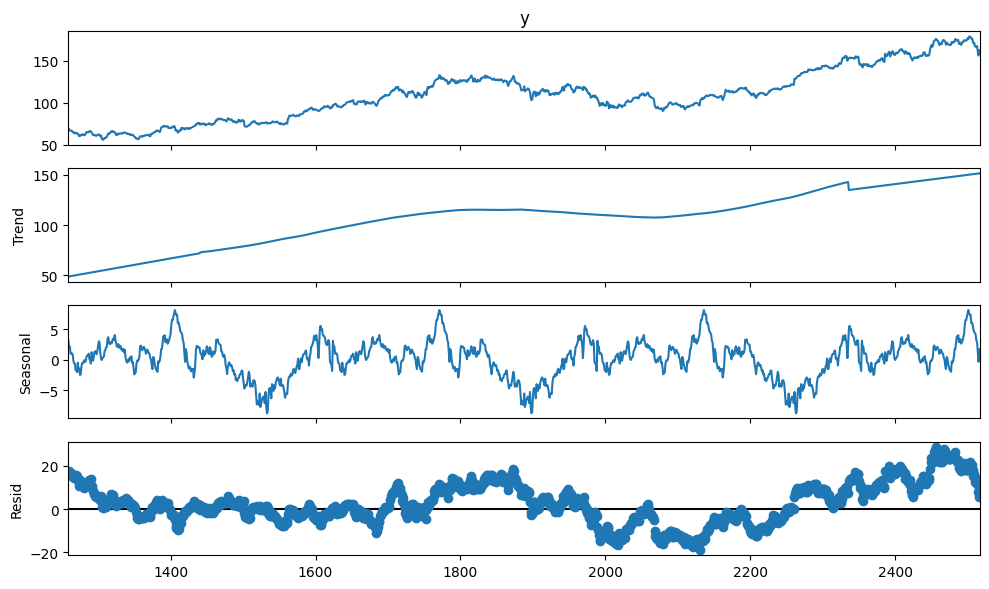

In [ ]:
# let's find seasonla decomposition of time-series models
def decomposition(df, period):
    # decompistion instance
    result_decom = seasonal_decompose(df['y'], model="additive",
                                      period=period, extrapolate_trend='freq')
    # plot the componenets
    fig = result_decom.plot()
    fig.set_size_inches((10, 6))
    # Tight layout to realign things
    fig.tight_layout()
    plt.show()

    # capture the compoenets
    trend = result_decom.trend
    season = result_decom.seasonal
    reside = result_decom.resid
    return trend, season, reside
# let's find compoenets for aapl stock price
tr, se, re = decomposition(aplph_df, 365)

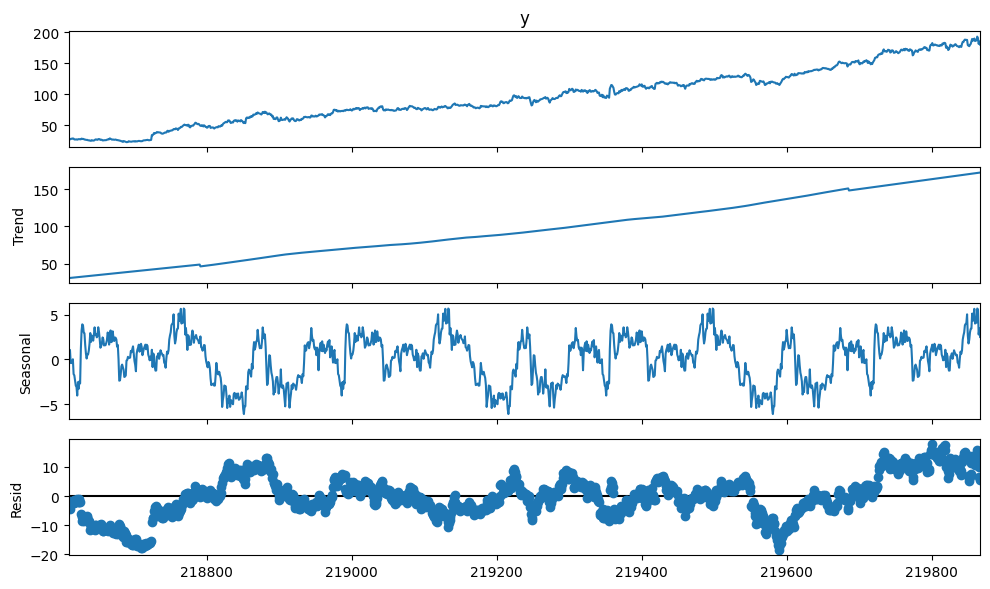

In [ ]:
# let's find out components for fb stock price
ftr, fse, fre = decomposition(fbph_df, 365)

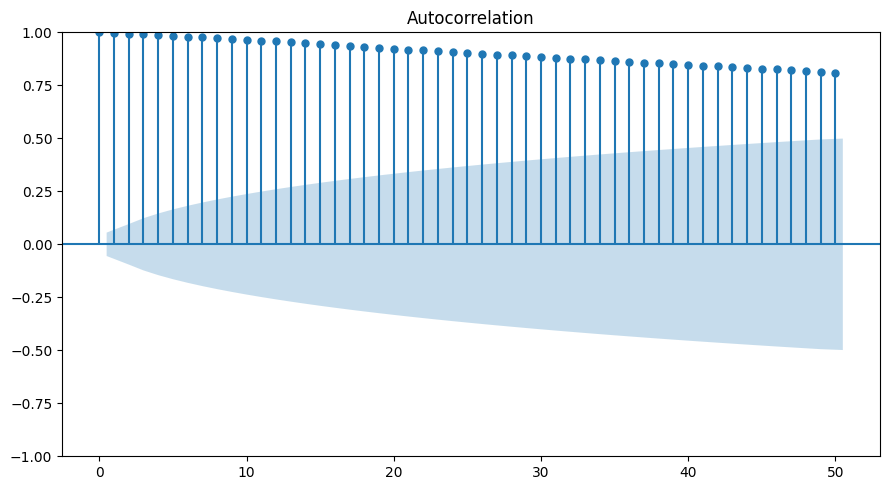

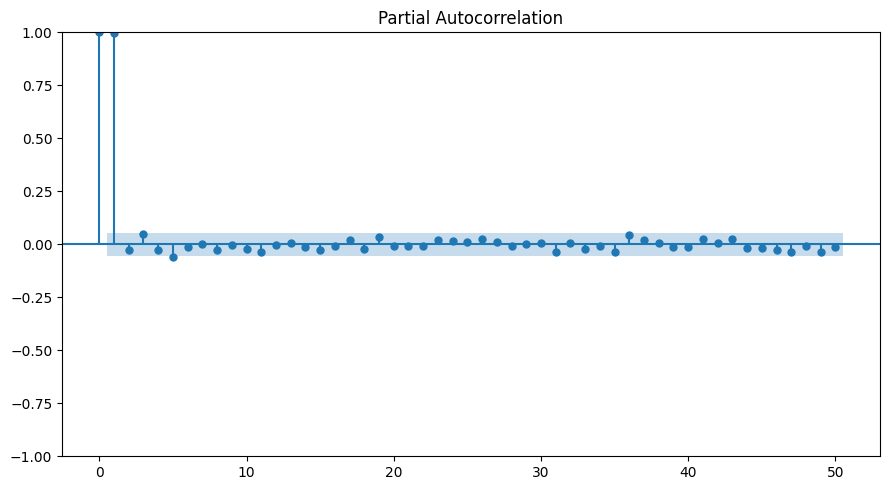

In [ ]:
# function to retunr acf and pacf plots
def acf_pacf(df, lags):
    var = df['y']
    # plot the acf plot
    fig = plot_acf(var, lags=lags)
    fig.set_size_inches((9, 5))
    fig.tight_layout()
    plt.show()

    # plot the pacf plots
    fig = plot_pacf(var, lags=lags)
    fig.set_size_inches((9,5))
    fig.tight_layout()
    plt.show()
# acf and pacf of aapl stock
acf_pacf(aplph_df, 50)


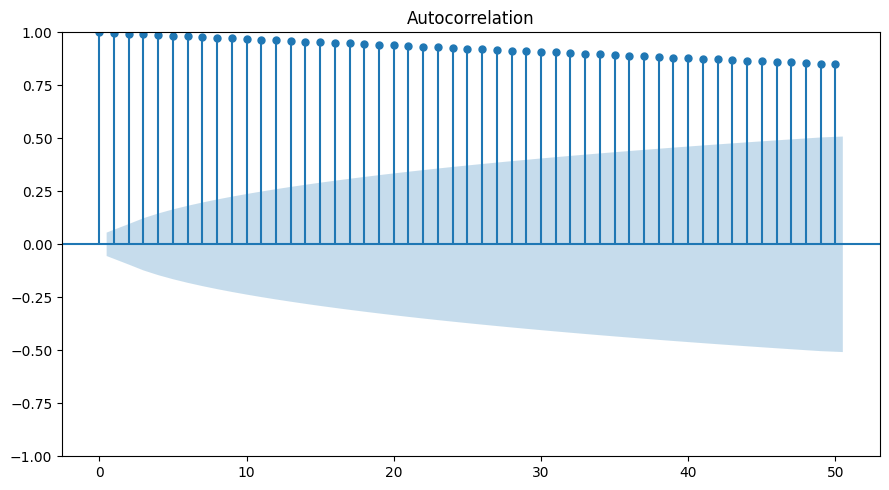

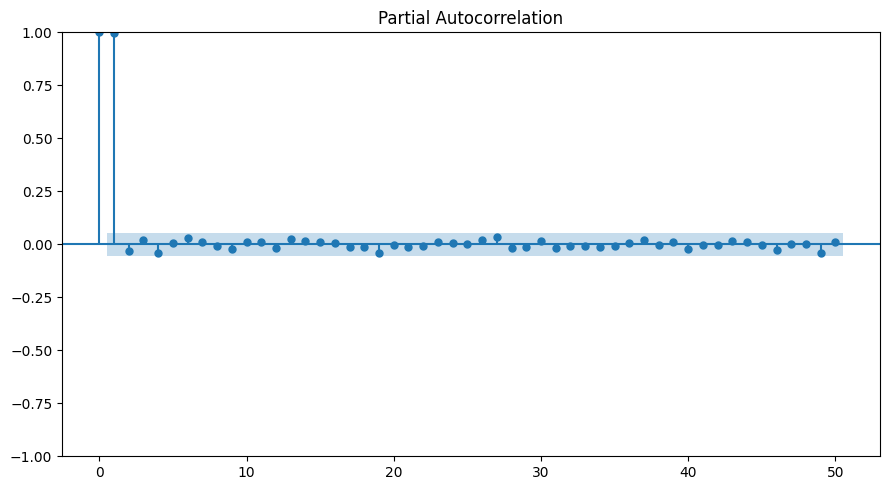

In [ ]:
# acf and pacf plots of FB
acf_pacf(fbph_df, 50)


In [ ]:
# funtion to return adfuller test results
def adfuller_test(df):
    adfuller_result = adfuller(df['y'], autolag='AIC')
    adfuller_output = pd.Series(adfuller_result[:4], index=['Test statistic', 'p-value',
                                                           'Lags Used','Number of Observations Used'])
    print(adfuller_output)


In [ ]:
print("adfuller test results for AAPLE")
adfuller_test(aplph_df)
print("----"*10)
print("adfuller test results for FB")
adfuller_test(fbph_df)


adfuller test results for AAPLE
Test statistic                   -0.665091
p-value                           0.855586
Lags Used                         0.000000
Number of Observations Used    1258.000000
dtype: float64
----------------------------------------
adfuller test results for FB
Test statistic                    0.177529
p-value                           0.970973
Lags Used                         8.000000
Number of Observations Used    1250.000000
dtype: float64


In [ ]:
# find degree of differencing
def degree_of_differencing(df, co_name):
    company_ndiffs = ndiffs(df['y'], test = 'adf')
    print(f'The degree of differencing is {company_ndiffs} for {co_name}')

    return company_ndiffs

aapl_ddf = degree_of_differencing(aplph_df, 'APPLE')
fb_ddf = degree_of_differencing(fbph_df, 'Facebook')


The degree of differencing is 1 for APPLE
The degree of differencing is 1 for Facebook


In [ ]:
# funcrtion to split train and test time-series for modelling purpose
def arima_split(df, co_name):
    size = int(len(df)*0.95)
    train_df = (df['y'])[:size]
    test_df = (df['y'])[size:]

    print(f"data splits of company {co_name}")
    print(f"Train Size: {len(train_df)}, Test Size: {len(test_df)}")
    print("-------------------------------")

    return train_df, test_df

apl_train, apl_test = arima_split(aplph_df, 'APPLE')
fb_train, fb_test = arima_split(fbph_df, 'FB')


data splits of company APPLE
Train Size: 1196, Test Size: 63
-------------------------------
data splits of company FB
Train Size: 1196, Test Size: 63
-------------------------------


In [ ]:
def find_best_fit_arima(df, co_name):
    print(f"Arima model for {co_name}")

    model = pm.auto_arima(df, test = 'adf',
                          start_p = 1, start_q = 1,
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')

    print(model.summary())
    print('\n')

    return model

model_apl = find_best_fit_arima(apl_train, 'APPLE')
model_fb = find_best_fit_arima(fb_train, 'FB')


Arima model for APPLE
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=3.83 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=5737.373, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=4795.557, Time=0.60 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=5191.240, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=5746.692, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=5067.196, Time=0.12 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=4657.095, Time=1.06 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=8.19 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=5740.397, Time=0.58 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=4647.664, Time=1.21 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=4777.434, Time=0.57 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=8.79 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=6.33 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   

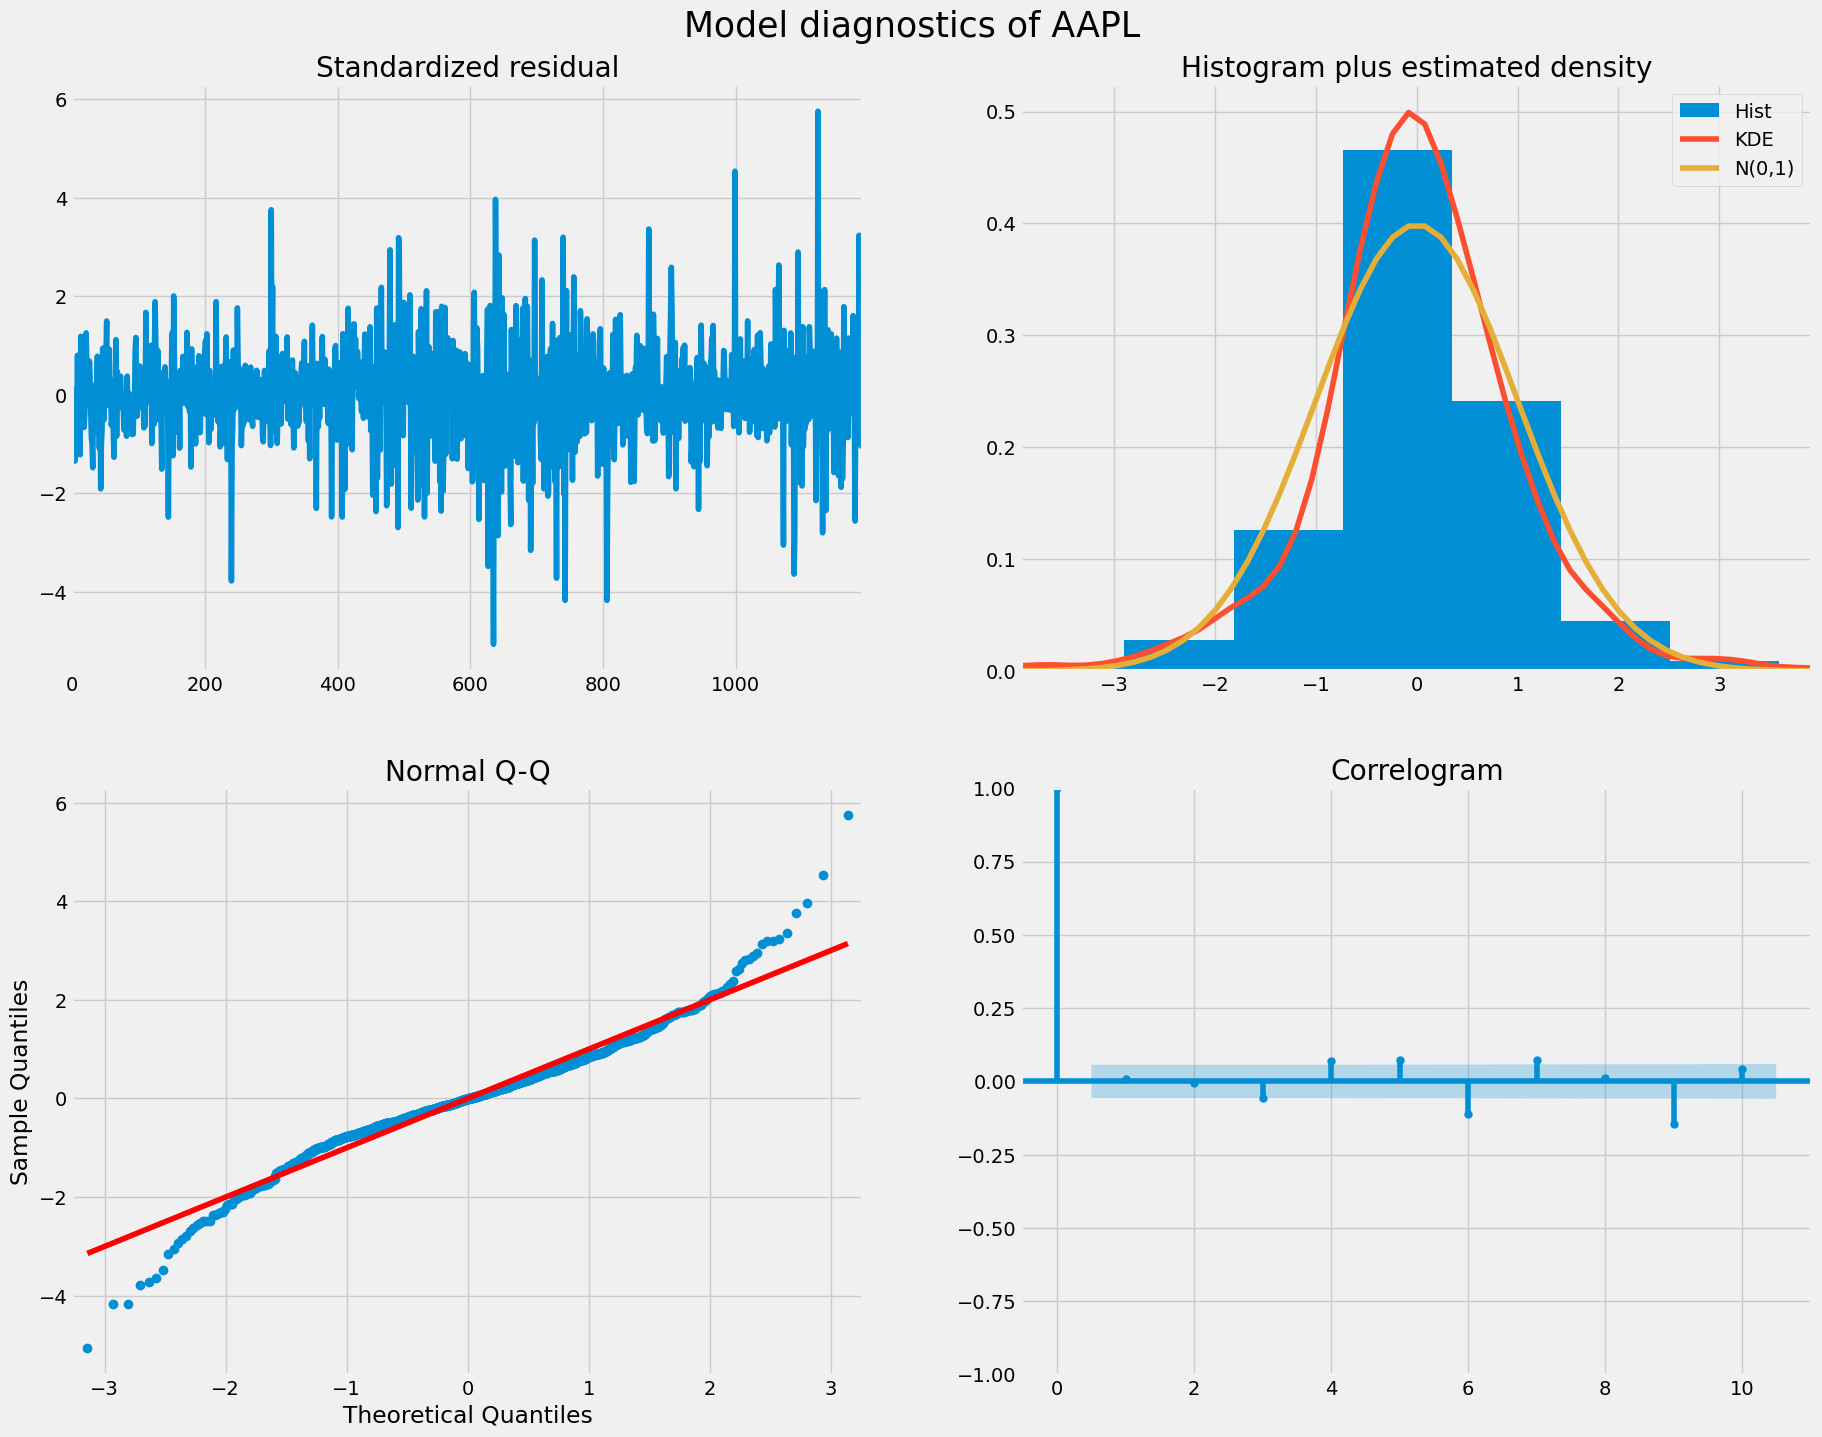

--------------------------------------------------------------------------------------------------------------------------------------------


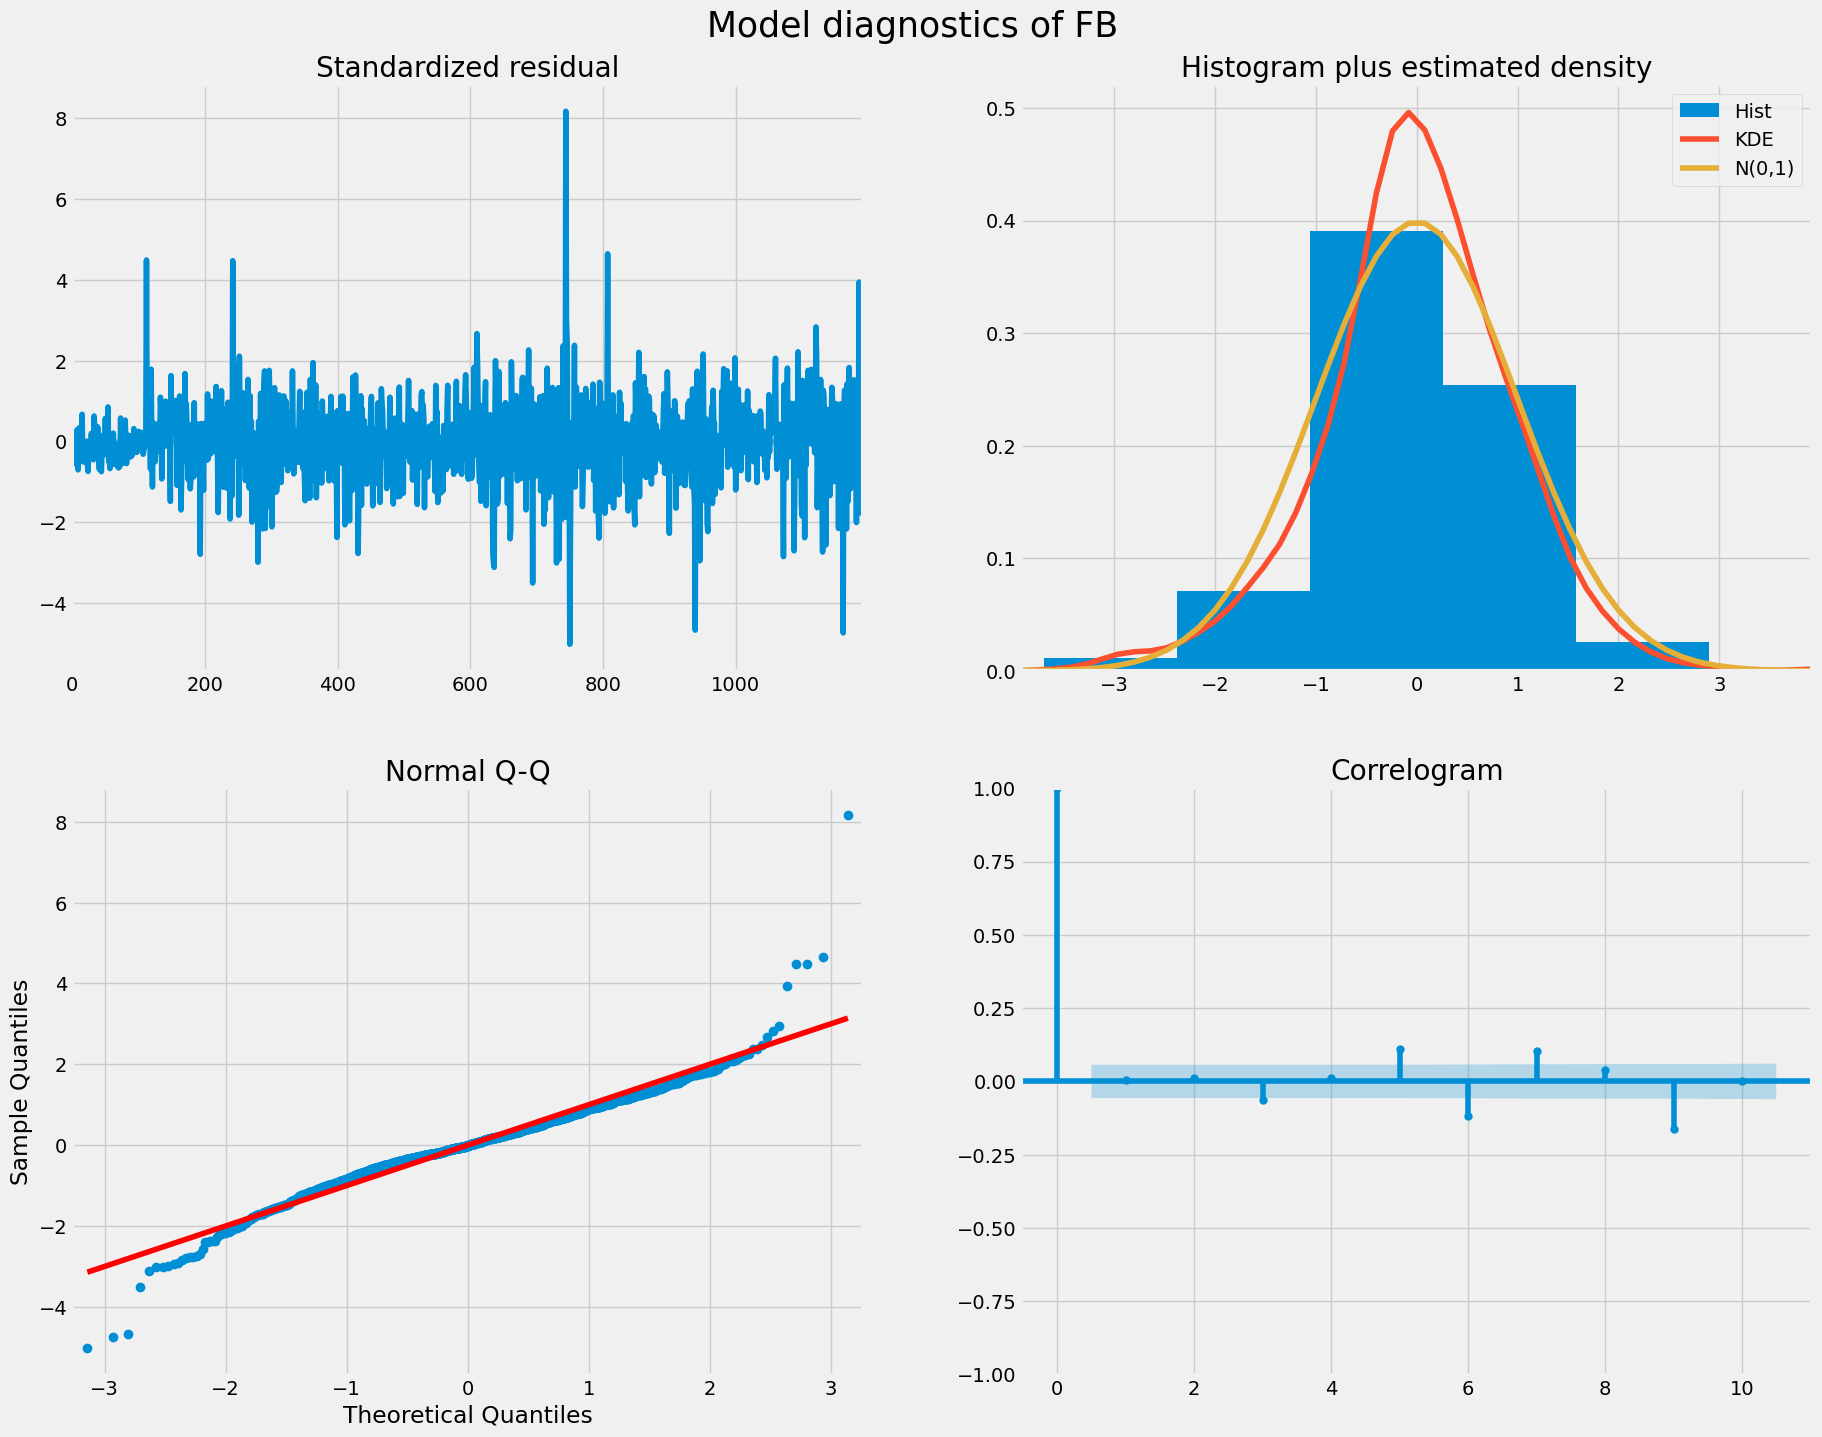

In [ ]:
# let's plot forecasting models plots
def display_model_plots(model, co_name):
    plt.style.use('fivethirtyeight')
    model.plot_diagnostics(figsize = (20, 15));
    plt.suptitle(f'Model diagnostics of {co_name}', fontsize = 25)
    plt.subplots_adjust(top = 0.93)
    plt.show()
    plt.style.use('default')

display_model_plots(model_apl, 'AAPL')
print("-------"*20)
display_model_plots(model_fb, 'FB')


In [ ]:
def make_predictions_and_print_rmse(model, test_df, co_name):
    print(f"forecasting and RMSE of {co_name}")

    forecast, confidence_interval = model.predict(X=test_df, n_periods = len(test_df), return_conf_int = True)
    forecasts = pd.Series(forecast, index = test_df[:len(test_df)].index)
    lower = pd.Series(confidence_interval[:, 0], index = test_df[:len(test_df)].index)
    upper = pd.Series(confidence_interval[:, 1], index = test_df[:len(test_df)].index)

    rmse = np.sqrt(np.mean((forecast.values - test_df.values) ** 2))

    print("RMSE is: ", rmse)

    return forecasts, lower, upper

forecast, lower, upper = make_predictions_and_print_rmse(model_apl, apl_test, 'APPLE')
print("----------------------------")
forecastf, lowerf, upperf = make_predictions_and_print_rmse(model_fb, fb_test, 'FB')


forecasting and RMSE of APPLE
RMSE is:  7.3028968743431095
----------------------------
forecasting and RMSE of FB
RMSE is:  4.205905947916905


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (945, 1)
Shape of Validation Set (314, 1)
Epoch 1/10
905/905 - 22s - loss: 0.0019 - 22s/epoch - 24ms/step
Epoch 2/10
905/905 - 19s - loss: 7.3388e-04 - 19s/epoch - 21ms/step
Epoch 3/10
905/905 - 18s - loss: 5.3026e-04 - 18s/epoch - 20ms/step
Epoch 4/10
905/905 - 19s - loss: 4.7381e-04 - 19s/epoch - 20ms/step
Epoch 5/10
905/905 - 19s - loss: 4.3628e-04 - 19s/epoch - 22ms/step
Epoch 6/10
905/905 - 20s - loss: 3.7453e-04 - 20s/epoch - 22ms/step
Epoch 7/10
905/905 - 19s - loss: 3.8654e-04 - 19s/epoch - 21ms/step
Epoch 8/10
905/905 - 19s - loss: 3.6649e-04 - 19s/epoch - 21ms/step
Epoch 9/10
905/905 - 19s - loss: 3.6806e-04 - 19s/epoch - 20ms/step
Epoch 10/10
905/905 - 18s - loss: 3.6719e-04 - 18s/epoch - 20ms/step
10/10 [==================

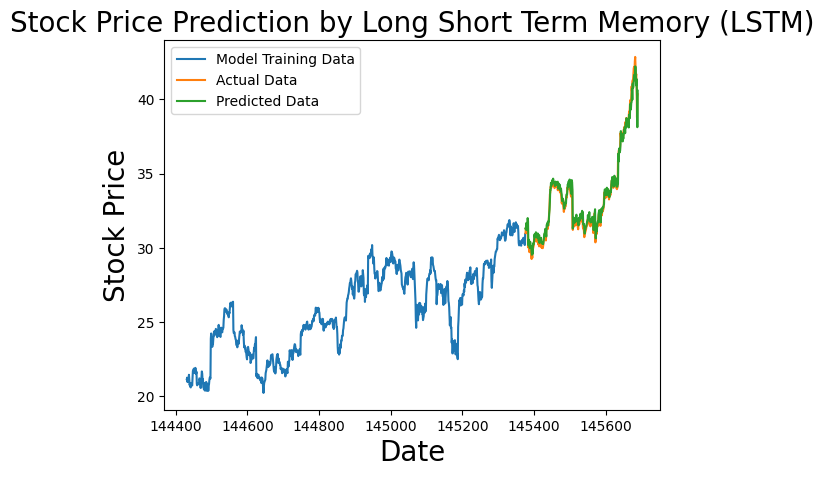

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from math import ceil
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

def lstm_prediction(df):
    shape = df.shape[0]
    df_new = df[['close']]

    dataset = df_new.values
    train = df_new[:ceil(shape * 0.75)]
    valid = df_new[ceil(shape * 0.75):]

    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set', train.shape)
    print('Shape of Validation Set', valid.shape)

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)

    x_train, y_train = [], []
    for i in range(40, len(train)):
        x_train.append(scaled_data[i-40:i, 0])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(x_train, y_train, epochs=10, batch_size=1, verbose=2)  # Increased epochs for demonstration

    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)

    X_test = []
    for i in range(40, inputs.shape[0]):
        X_test.append(inputs[i-40:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)

    rms = np.sqrt(np.mean(np.power((valid.values - closing_price), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')

    valid['Predictions'] = closing_price

    plt.plot(train['close'], label='Model Training Data')
    plt.plot(valid[['close', 'Predictions']], label=['Actual Data', 'Predicted Data'])
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)', size=20)
    plt.legend()
    plt.show()

# Assuming df is your DataFrame
lstm_prediction(df)


-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set (945, 1)
Shape of Validation Set (314, 1)
905/905 - 23s - loss: 0.0015 - 23s/epoch - 26ms/step
10/10 [==============================] - 1s 22ms/step


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3430: FutureWarning:

In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'



RMSE value on validation set: close    1.526076
dtype: float64
-----------------------------------------------------------
-----------------------------------------------------------


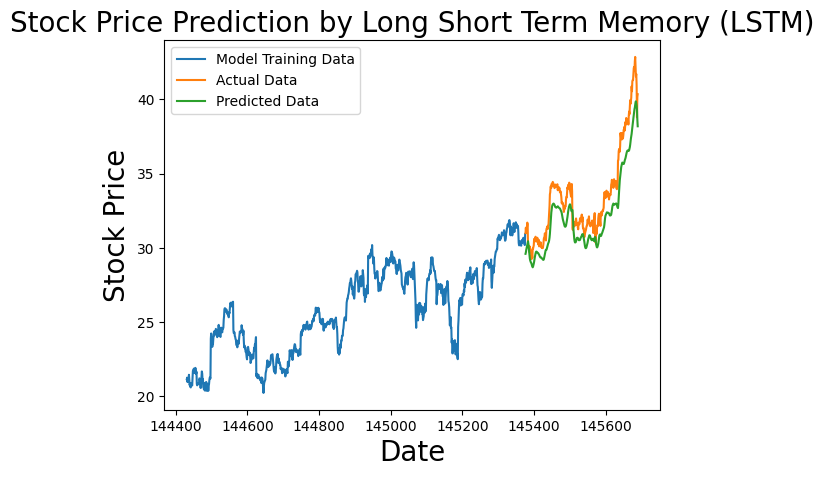

In [ ]:
def lstm_prediction(df):
    shape=df.shape[0]
    df_new=df[['close']]
    df_new.head()
    dataset = df_new.values
    train=df_new[:ceil(shape*0.75)]
    valid=df_new[ceil(shape*0.75):]
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set',train.shape)
    print('Shape of Validation Set',valid.shape)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    x_train, y_train = [], []
    for i in range(40,len(train)):
        x_train.append(scaled_data[i-40:i,0])
        y_train.append(scaled_data[i,0])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler.transform(inputs)
    X_test = []
    for i in range(40,inputs.shape[0]):
        X_test.append(inputs[i-40:i,0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    valid['Predictions'] = closing_price
    plt.plot(train['close'])
    plt.plot(valid[['close','Predictions']])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Price',size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])
lstm_prediction(df)